
# Generador de municipios
### Erick Fernando López Fimbres.  
#### erick.lopez.fimbres@gmail.com

## Definición

Para la realizacion de este programa usaremos Nivel de caracter minimo y puedes consultar el archivo original [aquí](https://gist.github.com/karpathy/d4dee566867f8291f086). 
El cual nos ayudara a generar nombres de municipios caracter por caracter a partir de los ya existentes que hay en México.


## Preparación de datos 

Si no tienes instalada la libreria unidecode ingresa el siguiente comando en Linux
```conda install -c anaconda unidecode```


In [20]:
import unidecode
import string
import random
import re

#para la clase RNN
import torch
import torch.nn as nn
from torch.autograd import Variable

all_characters = string.printable
n_characters = len(all_characters)

print(n_characters)

file = unidecode.unidecode(open('datos/municipios.txt').read())
file_len = len(file)
print('file_len =', file_len)

100
file_len = 35530


Ahora fragmentaremos el texto

In [18]:
longitud_fragmento = 200

def fragmento_aleatorio():
    i_ini = random.randint(0, file_len - longitud_fragmento)
    i_final = i_ini + longitud_fragmento + 1
    return file[i_ini:i_final]

print(fragmento_aleatorio())

Tenancingo
Tenancingo
Tenango de Doria
Tenango del Aire
Tenango del Valle
Tenejapa
Tenochtitlan
Tenosique
Teocaltiche
Teocelo
Teococuilco de Marcos Perez
Teocuitatlan de Corona
Teolocholco
Teoloyucan
T


## Construyendo el modelo



In [19]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

## Entradas y objetivos

In [21]:
# Convierta la cadena en una lista larga
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

Variable containing:
 10
 11
 12
 39
 40
 41
[torch.LongTensor of size 6]



In [22]:
def random_training_set():    
    chunk = fragmento_aleatorio()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

## Evaluando

Para evaluar la red la alimentaremos con un carácter a la vez, usaremos los resultados de la red como una distribución de probabilidad para el siguiente carácter y repetiremos este proceso.

In [23]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

## Entrenamiento

In [24]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [25]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

Luego definimos los parámetros de entrenamiento, instanciamos el modelo y comenzamos a entrenar:

In [26]:
n_epochs = 2000 #numero de epoch para el entrenamiento
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 36s (100 5%) 2.6499]
Whuestla
JChilllaco
Vila
Laritla
Ataran Tlollago
Tlacolilon
Tlacapalo
Entlal
Tlanton de Teutillco
Lani 

 6s (200 10%) 1.3219]
Whualco
Santo Juan Coman
Teratenaco
Oloncoscos
San Frerancianin
San Juate Ajapunadepen
Otaria Tlani
Sa 

 44s (300 15%) 1.4258]
Whila
Yabares
Tepec del el Cocaria
Teezaltepec
Tatla
Cuero
Tecotlan
Santa Pedrio del Ros Tepolo
Santa  

 17s (400 20%) 1.3585]
Whinta de Lacato
La Meguerta
Zaunande
Gualteco Temaxtimo Zaludalgo
San FepegaQuilpan
Cihuan de Galacoy 

 49s (500 25%) 1.8101]
Whuanani
Tamaragana
Tomenamelcas
Bonitoa
Berotota
Bonedaro
Bes de Escuila de Barania de Bo. de Oro
Nav 

 22s (600 30%) 1.2955]
Wha
Corminal
Catario
Monidor
Matepec
Matariz
Tepatla
MaTpane
Teycale
Tepequila
Tepelahuan
Telica
Teyat 

 10s (700 35%) 1.2947]
Whuas
Sinas
Santa Cosautiatas
Santo Chapas
San Juan Bautiste de Xotori
Santa Cruz Baria de Zapanga
Gua 

 47s (800 40%) 1.7483]
Whuacampa
Tetacolan
Tepelchi
Tepanchitla
Tomalilco
Texantingo
Tepaltepec
Tetarongo 

## Graficando los errores

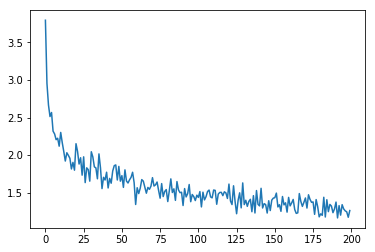

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Resultados con diferentes temperaturas 

En la función de evaluación anterior, cada vez que se realiza una predicción, las salidas se dividen por el argumento "temperatura" pasado. Usar un número más alto hace que todas las acciones sean más equitativas y, por lo tanto, nos brinda salidas "más aleatorias".

Usar un valor más bajo (menos de 1) hace que las probabilidades altas contribuyan más. A medida que aumentamos la temperatura hacia cero, estamos eligiendo solo las salidas más probables.

In [32]:
print(evaluate('R', 200, temperature=0.8))

Radredo
Nautitana
Huangenio
Huatonga
Huautla
Escalio
Escosac de Escuaro
Gueyateapan
Epatanero Estaba
Oconkua
Ocayeutla
Ololinco
Ocoomelgo Ocamoxos
Ococotepec
Nuevo de Mextarolo
Acatepec
Acayaco
Huayate


In [34]:
print(evaluate('R', 200, temperature=0.2))

Roya
Reyes de Reforma
La Pedro
La Loro Parisco Lardes Lucus Rorfida
La Unio
La Luis Rosas
La Mardenas
La Pedro Lagravo
La Pedro Loro Corolo Corta
La Magdalena Cardenas
La Pedro Loro
Lo Confor Los Rorfi


In [35]:
print(evaluate('Th', 200, temperature=1.4))

Thimunuluti
Salixtenahualca
Santa CurautimToa
Soyma
ildoria
La -
Panzo VetitFVelio Huatapan Perar Tumbre Hoyachisco
Tiul
Tepayu
Tejayuca
Tonotianadado
Genezor
IFrera
Alcuaro Velipas
Nazalaz
Depedores 
B


Las temperaturas mas altas dan salidas menos probables